In [1]:
%%time 
%reload_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from utils.imports import *
from utils.helpers import *
from utils.model import *

# instantiate model
device = 0
model, optimizer = initialize_model(vocab_size, device, learning_rate)

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
world_size = torch.cuda.device_count()
val_data = load_val_data(device, world_size)
list_num_tokens, list_num_tokens_eval, list_losses, list_losses_eval = [], [], [], {'train':[], 'val':[]}


/data/home/osafak/.conda/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


num_params: 89 M
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | context_length | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
|   512   |    12    |    8    |   64   |      1024      |     12     |     516096     |     6e-04     |
|         |          |         |        |                |   12/GPU   |                |               |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
len(val_data):500000  (0 sec)
CPU times: user 6.13 s, sys: 3.94 s, total: 10.1 s
Wall time: 2.09 s


In [1]:
start = time.time()
step = 0
sample_no = 0
num_tokens = 0
num_batches = 0

myvalset = MyDataset(val_data, block_size)
val_loader = torch.utils.data.DataLoader(dataset=myvalset,
                                         batch_size=batch_size,
                                         shuffle=False)

list_losses_val.append(estimate_loss(model, val_loader, device))
list_num_tokens_val.append(num_tokens)
plotter(device, list_num_tokens, list_losses, list_num_tokens_val, list_losses_val, savefig=True)
generate_text(model, device, step, None) 

while step < max_iters:
    step += 1

    # crawl a new batch of wiki pages
    train_data, num_chars = crawl_wiki_data(device, new_links, visited_urls, num_chars, add//10)

    # wrap the data in DataLoader class. 
    mydataset = MyDataset(train_data, block_size)
    train_loader = torch.utils.data.DataLoader(
        dataset=mydataset,
        batch_size=batch_size,
        shuffle=False,
    )

    for batch_no, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)
        yb = yb.to(device)
        mb1 = xb.element_size() * xb.nelement() * 1e-6
        mb2 = yb.element_size() * yb.nelement() * 1e-6
        logits, loss = model(xb, yb) # evaluate the loss
        print(f'batch_no:{batch_no+1} of {len(train_loader)},  loss:{loss.item():.2f}, Memory:{mb1 + mb2}MB ', end='\r')
        loss = loss.mean() # take average across the 8 GPUs
        optimizer.zero_grad(set_to_none=True)
        loss.backward() # get the gradients with backprop.
        optimizer.step() # apply the gradient on the network parameters.
        list_losses.append(loss.item())
        num_tokens += block_size * batch_size 
        list_num_tokens.append(num_tokens)

        # evaluate at fixed intervals
        if step % eval_steps == 0 and batch_no == (len(train_loader) - 1):
            print(f'step:{step:3d}')
            out = estimate_loss(model, val_data, val_data)
            list_losses_eval['train'].append(out['train'])
            list_losses_eval['val'].append(out['val'])
            list_num_tokens_eval.append(num_tokens)
            plotter(list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval, savefig=True)
            generate_text(model) 


    print(f'step:{step:3d} num_pages:{len(visited_urls):02d}  '+
          f'{"FINISHED " if step == max_iters else ""} train():{print_runtime(start, False)}', end ='\n')


In [ ]:
# train loop
train(model, optimizer, device, num_chars, val_data, 
      list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval, eval_steps)


In [ ]:
plotter(list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval)
generate_text(model)


# todo 
- ~Check if we're doing DDP across 8 GPUs correctly.~
- ~check if `batch_size` designates number of batches per each GPU or the total batches of 8 GPUs.~
- ~`get_batches` should get partial batches if it runs out of sentences~
- ~`get_batches` should process one wiki page at a time.~
- ~Use `tiktoken` tokenizer~


# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's nodes in a graph looking at each other and aggregating information with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking allows all tokens to communicate. **Decoder** uses `tril` masking in an autoregressive setting so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values come from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


----
## 1. Experiments

In [1]:
%%time
%reload_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from utils.imports import *
from utils.helpers import *
from utils.model import *

# instantiate model
device = 0
model, optimizer = initialize_model(vocab_size, device, learning_rate)

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
world_size = torch.cuda.device_count()
val_data = load_val_data(device, world_size)
list_num_tokens, list_num_tokens_eval, list_losses, list_losses_eval = [], [], [], {'train':[], 'val':[]}


/data/home/osafak/.conda/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


num_params: 304 M
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | context_length | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
|   1024  |    16    |    16   |   64   |      256       |     36     |     516096     |    3.00e-04   |
|         |          |         |        |                |   36/GPU   |                |               |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
len(val_data):500000  (0 sec)
CPU times: user 8.11 s, sys: 4.47 s, total: 12.6 s
Wall time: 4.9 s


In [2]:
train_data, _ = load_openwebtext_data()
q = 0
q0 = q * batch_size
q1 = (q+1) * batch_size + 1
data_step = torch.from_numpy(train_data[q0:q1].astype(np.int64))

context_length = 6
mytrainset = MyDataset(data_step, context_length=context_length)
train_loader = torch.utils.data.DataLoader(dataset=mytrainset,
                                           batch_size=(batch_size),
                                           shuffle=False,
                                           sampler=(mytrainset))
xb_big = data_step[:len(data_step)-1].view(1,-1).to('cpu')
yb_big = data_step[1:len(data_step)].view(1,-1).to('cpu')
model.to('cpu')
model.train()

logits, loss = model(xb_big, yb_big) # evaluate the loss
loss.backward() # Adds to the gradients
optimizer.step() # Updates the weights:  w = w - grad * lr


In [3]:
def get_grad_vector(model):
    list_grads = []
    dict_grads = dict()
    dict_weights = dict()
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            #print(f'{name:50s}', param.grad.shape)
            list_grads.append(param.grad.view(-1,1))
            dict_grads[name] = param.grad
            dict_weights[name] = param
        else:
            #print(f'=======> NO GRAD {name}')
            continue
    grad_vector = torch.cat(list_grads)  # gradient of the flattened weight vector
    return grad_vector, dict_grads, dict_weights

PATH = 'models/chkpt_02000.pt'
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model'])
grad_vector, dict_grads, dict_weights = get_grad_vector(model)
torch.linalg.norm(grad_vector)


tensor(11.0045)

blocks.2.attention.heads.1.W_Q.weight              -- (64, 1024)        0.07 M params
blocks.2.attention.heads.1.W_V.weight              -- (64, 1024)        0.07 M params
blocks.2.attention.heads.2.W_K.weight              -- (64, 1024)        0.07 M params
blocks.2.attention.heads.2.W_Q.weight              -- (64, 1024)        0.07 M params
blocks.2.attention.heads.2.W_V.weight              -- (64, 1024)        0.07 M params
blocks.2.attention.heads.3.W_K.weight              -- (64, 1024)        0.07 M params
blocks.2.attention.heads.3.W_Q.weight              -- (64, 1024)        0.07 M params
blocks.2.attention.heads.3.W_V.weight              -- (64, 1024)        0.07 M params


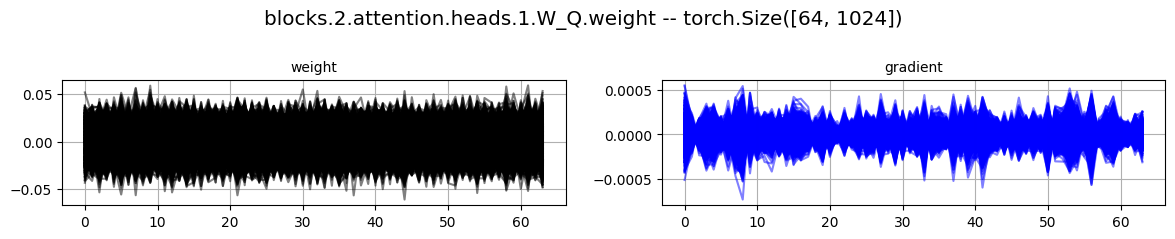

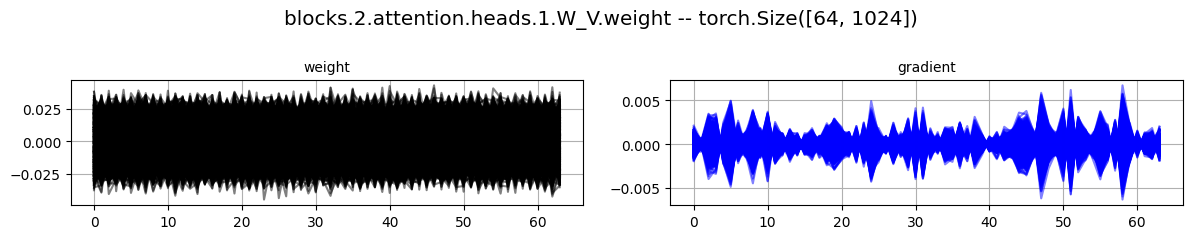

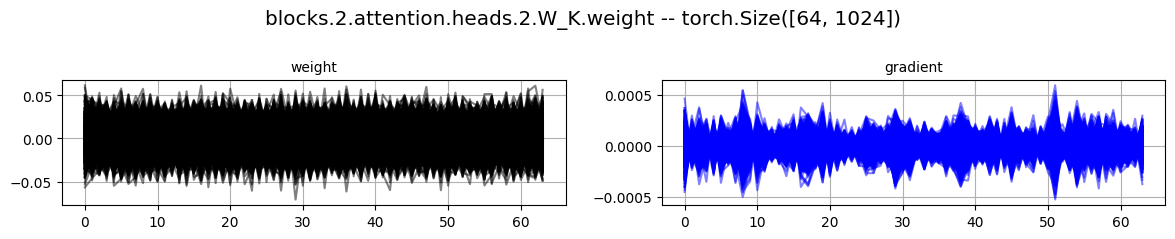

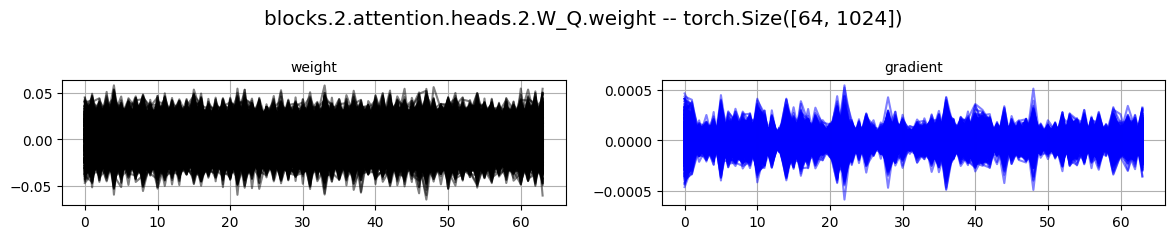

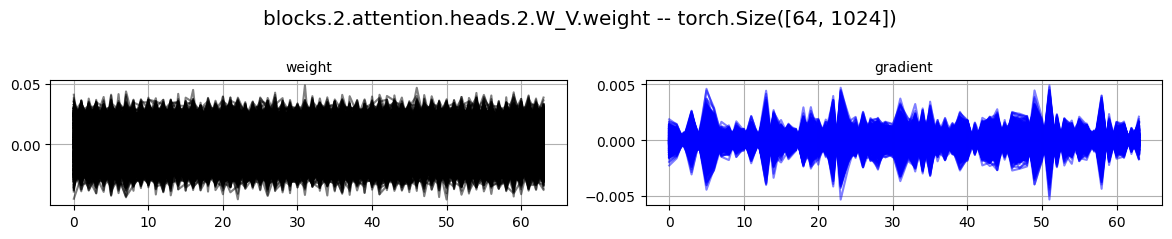

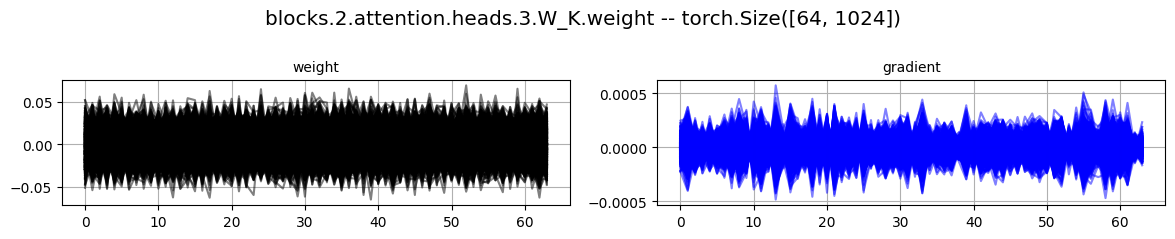

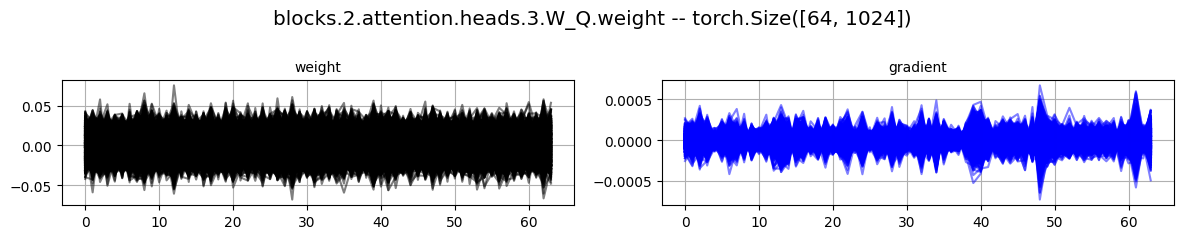

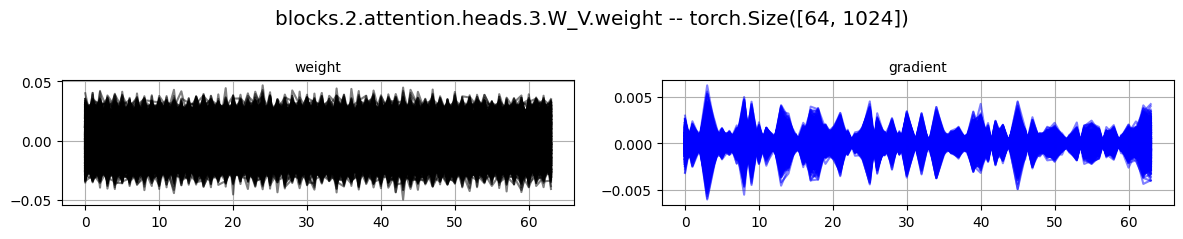

In [4]:
for i, (key, gradient) in enumerate(dict_grads.items()):
    if 120 < i < 130:
        print(f'{key:50s} -- {str(tuple(gradient.shape)):15s}  {np.prod(gradient.shape)/1e6:5.2f} M params')
        weight = dict_weights[key]
        fig = plt.figure(figsize=(4 * 3, 1.5 * 1.618))
        axs = fig.subplots(1, 2)
        
        axs[0].plot(weight.detach().numpy(), 'k-', alpha=.5)
        axs[0].set_title('weight')
        axs[1].plot(gradient, 'b-', alpha=.5)
        axs[1].set_title('gradient')
        fig.suptitle(f'{key} -- {gradient.shape}')
        plt.tight_layout()
    if i == 128:
         break
        

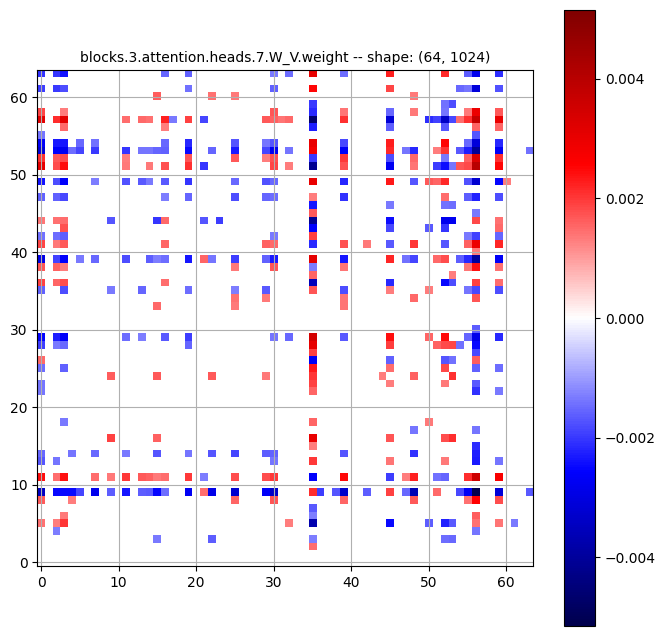

In [5]:
def imshow_grads(name=None, cutoff=0.25):
    if name is None:
        name = 'blocks.3.attention.heads.7.W_V.weight'
        
    z = dict_grads[name].clone()
    m, n = z.shape
    z = z[:min(m,n), :min(m,n)]
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()

    # filter out the small values
    b = (z_min*cutoff <= z).numpy().astype(np.int64)
    a = (z_max*cutoff >= z).numpy().astype(np.int64)
    mask = (a + b)
    z[mask==2] = np.nan

    fig = plt.figure(figsize=(8,8))
    c = plt.imshow(z, cmap='seismic', vmin=z_min, vmax=z_max,
                   interpolation='nearest', origin='lower')
    plt.colorbar(c)
    plt.title(f'{name} -- shape: {m,n}');
    torch.min(z), torch.max(z)
imshow_grads()

saved_runs/304M_shorcontext/output_1.log
saved_runs/304M_shorcontext/output_2.log
saved_runs/304M_shorcontext/output_3.log
saved_runs/304M_shorcontext/output_4.log
saved_runs/304M_shorcontext/output_5.log
last SGD step executed: 45115


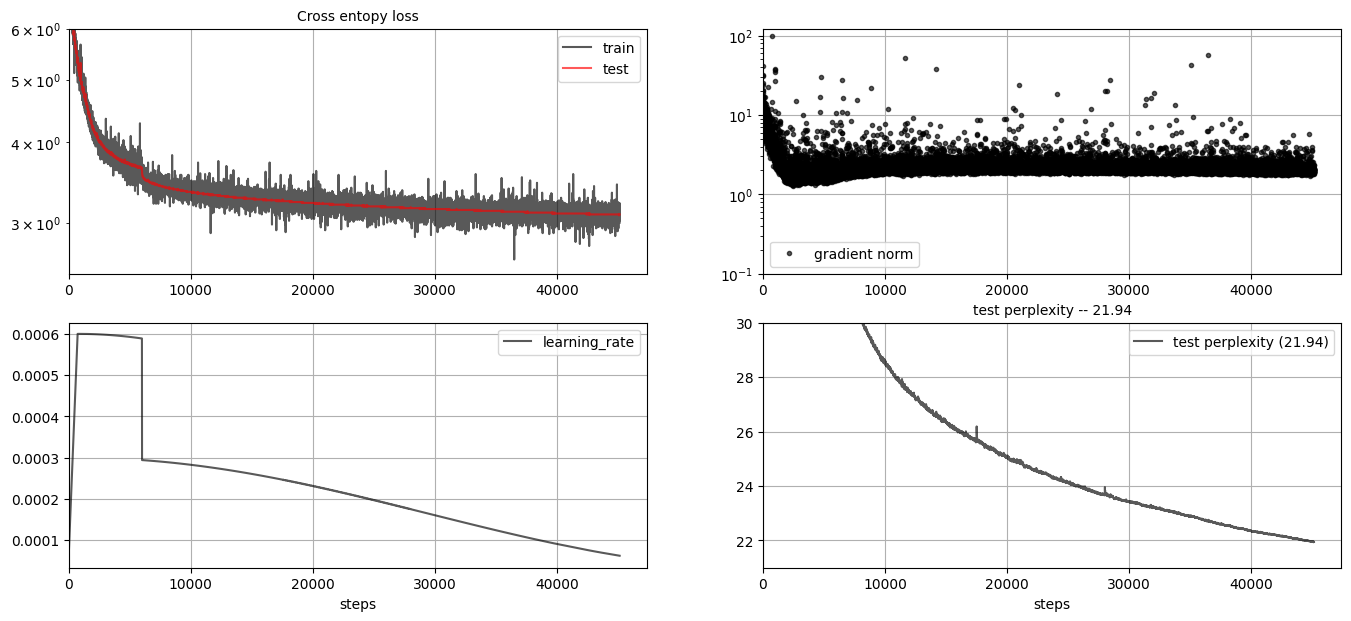

In [16]:
def plot_grads():
    # extract grad_norm from output.log file
    list_gradnorm, list_step, list_step_val, list_step, list_ppl_val = [None], [], [], [None], []
    list_loss, list_loss_val, list_lr = [None], [], [None]

    log = []
    for path in sorted(glob.glob('saved_runs/304M_shorcontext/output*.log')):
        with open(path, 'r') as f:
            log += f.readlines()
            print(path)

    for i, line in enumerate(log):
        #print(line, end='')
        if '. step:' in line:
            list_loss.append(float(line.split(' -- loss:')[1].split(' -- ')[0] ))
            if ' -- lr' in line:
                list_lr.append(float(line.split(' -- lr:')[1].split(' -- ')[0] ))
            if 'grad_norm1' in line:
                line = line.replace('grad_norm1', 'grad_norm')
            list_gradnorm.append(float(line.split('grad_norm:')[1].split(' -- ')[0]))
            list_step.append(int(line.split('step:')[1].split(' -- ')[0]))
        elif line.startswith('=> Testset '):
            list_loss_val.append(float(line.split(' -- loss:')[1].split(' ')[0] ))
            list_ppl_val.append(float(line.split('ppl:')[1].split(' -- loss:')[0]))
            list_step_val.append(list_step[-1])

    fig, axs = plt.subplots(2, 2, figsize=(3.5 * 3.236 * 1.45, 7))
    axs[0,1].semilogy(list_step, list_gradnorm,'k.', alpha=.65, label='gradient norm')
    axs[0,1].set_ylim(.1)
    axs[0,1].set_xlim(0)

    axs[1,1].plot(list_step_val, list_ppl_val[:len(list_step_val)], 'k-', alpha=.65, label=f'test perplexity ({min(list_ppl_val):.2f})')
    axs[1,1].set_ylim(21, 30)
    axs[1,1].set_title(f'test perplexity -- {min(list_ppl_val):.2f}')
    
    axs[0,0].semilogy(list_step, list_loss, 'k', label='train', alpha=.65)
    axs[0,0].semilogy(list_step_val, list_loss_val, 'r', label='test', alpha=.65)
    axs[0,0].set_ylim(2.5, 6)
    axs[0,0].set_title('Cross entopy loss')
    
    axs[1,0].plot(list_step, list_lr, 'k', alpha=.65, label='learning_rate')
    
    [ax.set_xlim(0) for row in axs for ax in row ]
    [ax.legend() for row in axs for ax in row ]
    [ax.set_xlabel('steps') for ax in axs[1]]
    print('last SGD step executed:', int(list_step_val[-1]))
    return list_loss, list_loss_val, list_gradnorm, list_step, list_step_val, list_ppl_val, list_lr

list_loss, list_loss_val, list_gradnorm, list_step, list_step_val, list_ppl_val, list_lr = plot_grads();

output.log
last SGD step executed: 10700


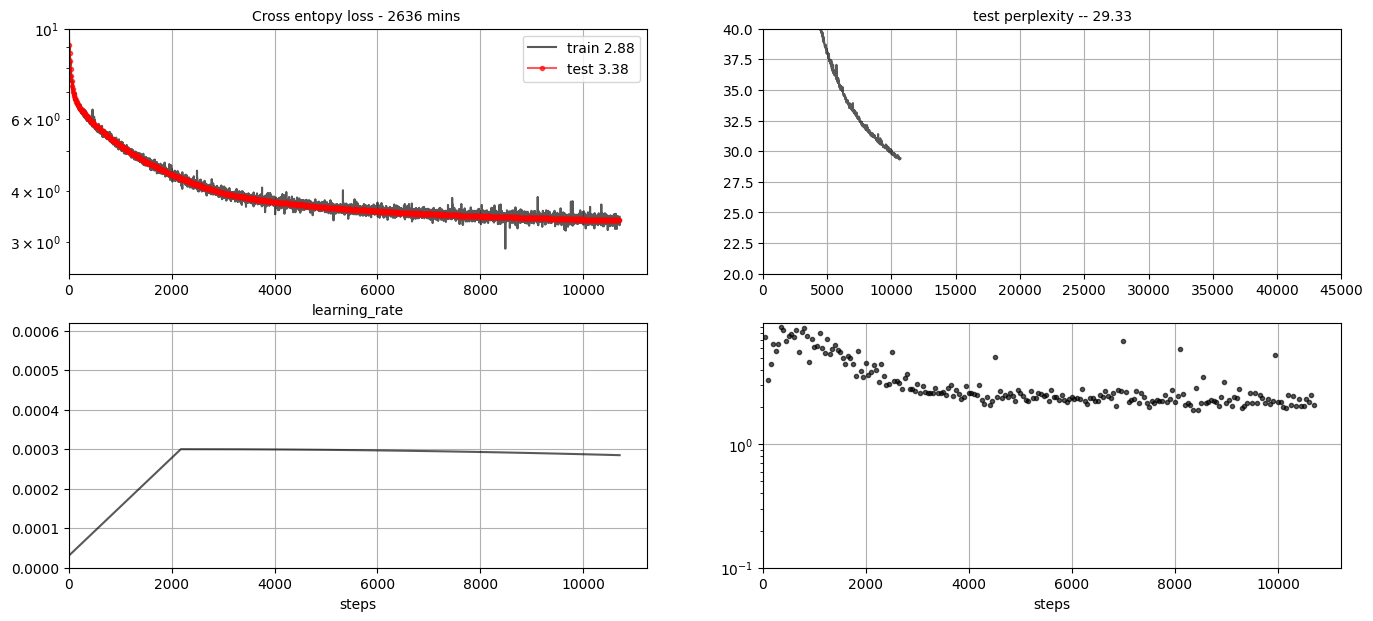

In [23]:
def plot_grads():
    # extract grad_norm from output.log file
    list_gradnorm, list_step_val, list_step, list_ppl_val = [None], [], [0], []
    list_loss, list_loss_val, list_lr = [None], [], [None]
    list_time, list_time_val = [0], []

    log = []
    for path in ['output.log']:
        with open(path, 'r') as f:
            log += f.readlines()
            print(path)
            
    for i, line in enumerate(log):
        if '. step:' in line:
            list_loss.append(float(line.split(' -- loss:')[1].split(' -- ')[0] ))
            if ' -- lr' in line:
                list_lr.append(float(line.split(' -- lr:')[1].split(' -- ')[0] ))
            list_gradnorm.append(float(line.split('grad_norm:')[1].split(' -- ')[0]))
            list_step.append(int(line.split('step:')[1].split(' -- ')[0]))
            tm = line.split('secs -- (')[1].split(')')[0]
            minute = int(tm.split('min')[0]) if 'min' in tm else 0 
            sec = int(tm.split('min')[1].split('sec')[0]) if 'min' in tm else int(tm.split('sec')[0])
            list_time.append(minute + sec/60)
        elif line.startswith('=> Testset '):
            list_loss_val.append(float(line.split(' -- loss:')[1].split(' ')[0] ))
            list_ppl_val.append(float(line.split('ppl:')[1].split(' -- loss:')[0]))
            list_step_val.append(list_step[-1])
            list_time_val.append(list_time[-1])

    fig, axs = plt.subplots(2, 2, figsize=(3.5 * 3.236 * 1.45, 7))
    axs[0,0].semilogy(list_step, list_loss, 'k', label=f'train {min2(list_loss)}', alpha=.65)
    axs[0,0].semilogy(list_step_val, list_loss_val, 'r.-', label=f'test {min2(list_loss_val)}', alpha=.65)
    axs[0,0].set_ylim(2.5, 10)
    axs[0,0].set_title(f'Cross entopy loss - {list_time[-1]:.0f} mins ')
    axs[0,0].legend()
    
    axs[0,1].plot(list_step_val, list_ppl_val, 'k-', alpha=.65, label=f'test perplexity ({min(list_ppl_val):.2f})')
    axs[0,1].set_ylim(20, 40)
    axs[0,1].set_xlim(0, 45000)
    axs[0,1].set_title(f'test perplexity -- {min(list_ppl_val):.2f}')
    
    axs[1,0].plot(list_step, list_lr, 'k', alpha=.65)
    axs[1,0].set_title('learning_rate')
    axs[1,0].set_ylim(0,6.2e-4)
    
    axs[1,1].semilogy(list_step, list_gradnorm,'k.', alpha=.65, label='gradient norm')
    axs[1,1].set_ylim(.1)

    [ax.set_xlim(0) for row in axs for ax in row]
    [ax.set_xlabel('steps') for ax in axs[1]]
    print('last SGD step executed:', int(list_step_val[-1]))
    return list_loss, list_loss_val, list_gradnorm, list_step, list_step_val, list_ppl_val, list_lr, list_time

list_loss, list_loss_val, list_gradnorm, list_step, list_step_val, list_ppl_val, list_lr, list_time = plot_grads();

---

num_params: 89 M
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | context_length | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
|   512   |    12    |    8    |   64   |      1024      |     12     |     516096     |     6e-04     |
|         |          |         |        |                |   12/GPU   |                |               |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
(7 sec)                  


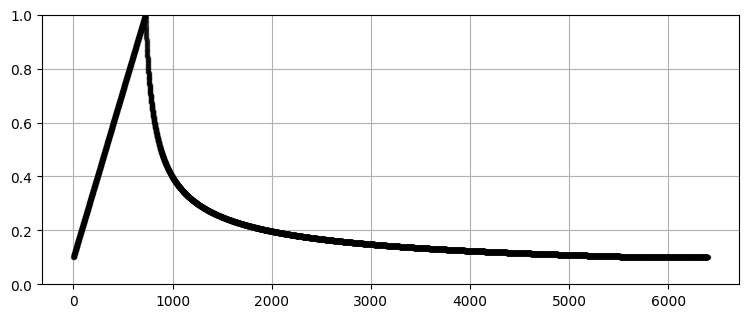

In [61]:
from utils.model import *
from utils.imports import *
start = time.time()
list_step, list_lr = [], []

_, optimizer = initialize_model(vocab_size, device, 1)
lr_scheduler = WarmupInvXDecay(optimizer, x0, x1) 

for num_tokens in range(0, int(x1*1.1), acc_batch_size):
    step = num_tokens / (acc_batch_size)
    if num_tokens > 0:
        print(f'{num_tokens / int(x1*1.1) *100:.1f} %', end='\r')
        
    optimizer.step()
    lr_scheduler.step()
    list_lr.append(optimizer.param_groups[-1]['lr'])
    list_step.append(step)

plt.plot(list_step, list_lr, 'k.-', alpha=.5)
plt.ylim(0,1)
print(f'{print_runtime(start, False)}                  ')

num_params: 89 M
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | context_length | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
|   512   |    12    |    8    |   64   |      1024      |     12     |     516096     |     6e-04     |
|         |          |         |        |                |   12/GPU   |                |               |
+---------+----------+---------+--------+----------------+------------+----------------+---------------+
Runtime: 0 min  6 sec100)


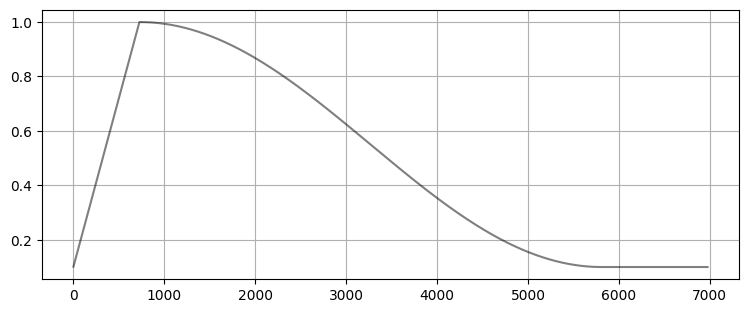

In [854]:
from utils.model import *
from utils.imports import *
start = time.time()

x0 = 0.375e9 # num_tokens at end of Linear warm up
x1 = 30e9  # num_tokens at end of Cosine Annealing or Hyperbolic Decay
_, optimizer = initialize_model(vocab_size, device, learning_rate)

lr_scheduler = WarmupCosineAnnealing(optimizer, x0, x1) 
x, list_lr = [], []

for step in range(0, int(x1*1.2), acc_batch_size):
    optimizer.step()
    lr_scheduler.step()
    list_lr.append(optimizer.param_groups[-1]['lr'] / learning_rate)
    x.append(step / acc_batch_size)
    print(f'{step/x1*100:5.2f} % -- ({x[-1]:.0f}, {list_lr[-1]:.3f})', end='\r')

plt.plot(x, list_lr, 'k', alpha=.5)
print_runtime(start)

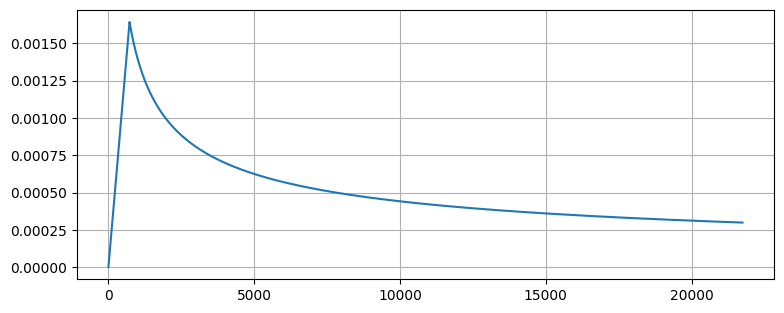

In [69]:
# Attention is All You Need
warmup_steps = 725
x, lr = [], []
for step_num in range(1, 30 * warmup_steps):
    x.append(step_num)
    lr.append((d_model ** (-0.5)) * min(step_num ** (-0.5), step_num * warmup_steps **(-1.5)))
plt.plot(x, lr)



In [734]:
eot = 50256
B, T = 70, 512
span = B * T * 1


In [ ]:
for step in range(350,400):
    i = step * B * T * 7
    print(f"\n{'---'*20}\nstep:{step}, i:{i}")
    
    x = torch.from_numpy(train_data[i:i+span*7].astype(np.int64))
    # x = x.view(B,T)

    eot_mask = torch.tril(torch.ones(batch_size, T, T))
    sum_1 = torch.sum(eot_mask)
    print(x.shape)
    print(f"number of EOS's: {torch.sum(x == eot)}")



------------------------------------------------------------ step:350, i:87808000
torch.Size([250880])
number of EOS's: 232

------------------------------------------------------------ step:351, i:88058880
torch.Size([250880])
number of EOS's: 196

------------------------------------------------------------ step:352, i:88309760
torch.Size([250880])
number of EOS's: 197

------------------------------------------------------------ step:353, i:88560640
torch.Size([250880])
number of EOS's: 222

------------------------------------------------------------ step:354, i:88811520
torch.Size([250880])
number of EOS's: 243

------------------------------------------------------------ step:355, i:89062400
torch.Size([250880])
number of EOS's: 255

------------------------------------------------------------ step:356, i:89313280
torch.Size([250880])
number of EOS's: 225

------------------------------------------------------------ step:357, i:89564160
torch.Size([250880])
number of EOS's: 227


In [677]:
%%time
idx = (x == eot).nonzero(as_tuple=True)
dummy = eot_mask.clone()

for b, t in zip(*idx):
    eot_mask[b,t:,:t] = 0
    

CPU times: user 613 ms, sys: 1.04 s, total: 1.65 s
Wall time: 77.8 ms


In [655]:
idx

(tensor([ 0,  2,  3,  9, 12, 13, 18, 20, 20, 22, 24, 30, 35, 36, 38, 40, 43, 44,
         45, 46, 47, 50, 54, 55, 56, 57, 58, 59, 60, 61, 61, 64, 64, 67, 67, 68,
         69]),
 tensor([428, 172, 261,  10, 240, 171,  37,  89, 493,  76, 389, 375,  59, 288,
          87,  29, 383, 238, 274, 134, 376, 373,  80, 282, 312, 217,  79, 496,
         278, 187, 507,  48, 236, 140, 465, 233,  66]))

In [607]:
t = 493
eot_mask[20,t-5:t+5,t-5:t+5]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])

In [327]:
span = block_size * 4
i = np.random.randint(len(train_data) - span)
print(decode(train_data[i:i+span]))


 onto the tracks, forcing the closure of the Metro station and causing disruptions to Amtrak and MARC service.

Sixteen cars slammed off the tracks near a heavily populated neighborhood. No injuries were reported, and the chemicals pose no immediate danger to the public, D.C. Assistant Fire Chief John Donnelly and CSX spokeswoman Kristin Seay said.<|endoftext|>Nick Fetty | September 5, 2014

The college football season is underway as the Hawkeyes, Cyclones, and hundreds of other teams from all across the country take to the field for the more than century-old tradition. However, scientists from two Big Ten universities are putting their differences aside and teaming up to develop more environmentally friendly lawns.

Researchers from Rutgers University and the University of Minnesota – both members of the Committee on Institutional Cooperation – will work together on a five-year study to develop a strain of grass unaffected by disease and drought while remaining affordable for consumer

In [650]:
a = torch.tensor([[1,2,3],[1,2,3],[1,2,3]])
print(a.shape)
tril = torch.tril(torch.ones(len(a), len(a)))
a.masked_fill(tril == 0,  f)


torch.Size([3, 3])


tensor([[1., -inf, -inf],
        [1., 2., -inf],
        [1., 2., 3.]])

## 2. Experiments
---

---

1
1


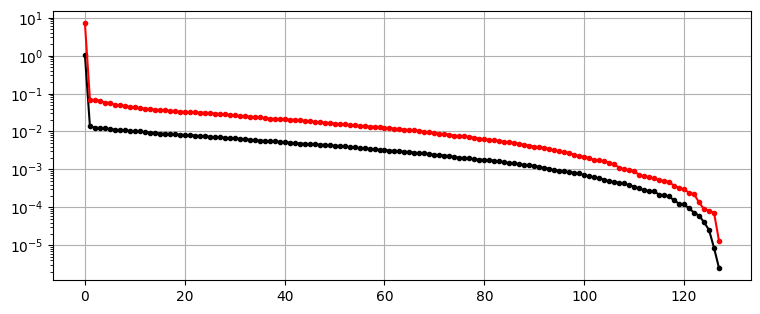

In [110]:
def softmax(logits):
    return np.exp(logits) / np.sum(np.exp(logits), axis=-1)
# ------------------------------------------------------------------

d_k = 16
n_heads = 8
d_model = d_k * n_heads

K = [None for _ in range(n_heads)]
Q = [None for _ in range(n_heads)]
a = [None for _ in range(n_heads)]

for i in range(n_heads):
    K[i] = np.random.rand(d_model, d_k)
    Q[i] = np.random.rand(d_model, d_k)
    a[i] = softmax(np.matmul(Q[i], K[i].T / np.sqrt(d_k)))  # low rank (d_model, d_model) matrix
    
K = np.concatenate(K, axis=-1)
Q = np.concatenate(Q, axis=-1) 
A = softmax(np.matmul(Q, K.T / d_k))

for i in range(2, n_heads):
    a[0] += a[i]
a = a[0] 

u, s, vh = np.linalg.svd(A)
plt.semilogy(s, 'k.-')
print(np.linalg.matrix_rank(s))

u, s, vh = np.linalg.svd(a)
plt.semilogy(s, 'r.-')
print(np.linalg.matrix_rank(s))


In [ ]:
"""
A) explain the algorithm (detailed steps) of K-mean clustering
 1) INPUT: X (n, d): data matrix, n: number of samples, d is dimension of the embeddings, 
           k: number of cluster
 2) Initialize centroids (k, d), prev_centroids
 
 while : 
 3) compute Euclidean dist (or cosine). distance (n, k)
 4) labels = np.argmin ( dist, axis=1)  # (n)
 5) Recompute the centroids array. k-th centroid:  centroid[k] = np.mean(X[labels == k])
 6) if prev_centroids == centroids:
        return centroids
    else:
        prev_centroids = centroids
        goto line 3)
 
"""



"""
B) Return if the input parentheses string is in legal format

---------------------------
Example 1:

Input: s = "((())"
Output: false

---------------------------
Example 2:

Input: s = ")()"
Output: false

--------------------------
Example 3:

Input: s = "))((("
Output: false

--------------------------
Example 4:

Input: s = "(())()"
Output: true

--------------------------
Example 5:

Input: s = ""
Output: true
"""

def is_matching(s):
    """ ex1. s = "((())"  -> False 
        ex1. s = ")()"    -> False
        ex3. s = "))((("  -> False
        ex4. s = "(())()" -> True
        ex5. s = ""       -> True
    """
    
    stack = []
    for c in s:
        if c == '(':
            stack.append('(')
        else: # ')'
            if not stack:
                return False
            if stack[-1] == '(':
                stack.pop()
                
    if not stack:
        return True
            
    return False

def is_ok():
    test = [ "((())", ")()" , "))(((", "(())()", ""]
    res = [False, False, False, True, True]
    
    for i, item in enumerate(test):
        print(test[i], is_matching(item) == res[i])
is_ok()
    

"""SNAP"""

# # list of flights
# # "LAX", "SFO", $50
# # "SFO", "SEA", $100
# # "LAX", "SEA", $200
# # query
# # ("LAX", "SEA", 0) → $200
# # ("LAX", "SEA", 1) → $150


"""
INPUT: flights = [(LAX", "SFO", $50), ("SFO", "SEA", $100), ("LAX", "SEA", $200)]
       query: ("LAX", "SEA", 0) 
"""

from collections import defaultdict, deque

def findFlights(query, flights):
    start_city, dest_city, max_stops = query
    G = defaultdict(lambda: dict())  
    
    # LAX: {SFO:50, NYC:230, ...}
    for c1, c2, price in flights:
        G[c1][c2] =  price
    
    queue = deque([(start_city, 0, 0)])
    out = float('inf')
    
    while queue:
        city, num_stops, total_price = queue.popleft()
        
        for dest, price in G[city].items():
            if num_stops > max_stops:
                break
                
            if dest == dest_city:
                out = min(out, total_price+price)
                
            queue.append((dest, num_stops+1, total_price+price))
            
    return out


flights = [("LAX", "SFO", 50), ("SFO", "SEA", 100), ("LAX", "SEA", 200)]
query1 = ("LAX", "SEA", 0)  # 200
query2 = ("LAX", "SEA", 1)  # 150
query = query1
print(findFlights(query, flights)) 

    
'''
design a utility function for ranking



'''        
        
        
        
        
    
    
    
    
    


---
## Positional Embeddings

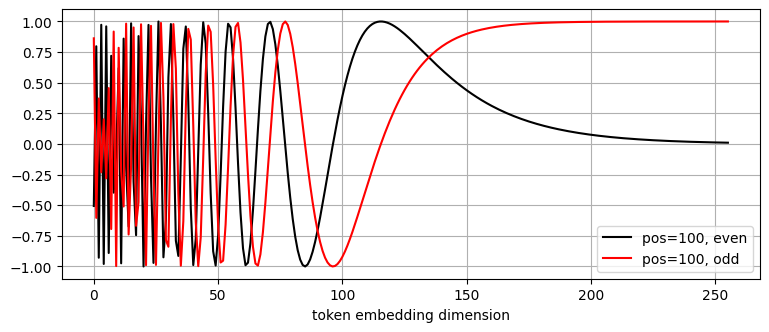

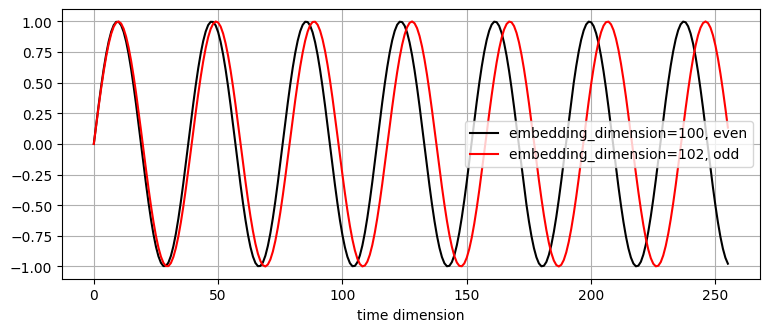

In [26]:
context_length = 256
d_model = 512

pe = torch.zeros(context_length, d_model) # [256, 512]
pos = torch.arange(0, context_length).unsqueeze(1) # [256, 1]
two_i = torch.arange(0, d_model, 2)
denominator = 10000.0 ** (two_i / d_model)
pe[:, 0::2] = torch.sin(pos / denominator)
pe[:, 1::2] = torch.cos(pos / denominator)

t = 100
plt.plot(pe[t, 0::2], 'k', label=f'pos={t}, even');
plt.plot(pe[t, 1::2], 'r', label=f'pos={t}, odd');
plt.xlabel('token embedding dimension')
plt.legend()

plt.figure()
i = 100
j = 102
plt.plot(pe[:, i], 'k', label=f'embedding_dimension={i}, even');
plt.plot(pe[:, j], 'r', label=f'embedding_dimension={j}, odd');
plt.xlabel('time dimension')
plt.legend()


# e = 255
# plt.plot(pe[:, 2*e], 'k', label='even');
# plt.plot(pe[:, 2*e+1], 'r', label='odd');

/data/home/osafak/.conda/envs/torch/lib/python3.8/site-packages/umap/utils.py:134: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit('i8(f8[:,:,:],i8,f8,i8,i8)')
/data/home/osafak/.conda/envs/torch/lib/python3.8/site-packages/umap/umap_.py:802: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


Text(0.5, 1.0, 'dot products between an i-th token and a pivot token in input sequence, $i = pivot, ... n$')

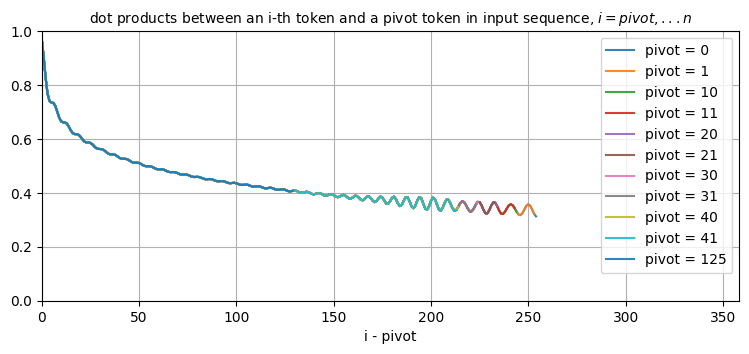

In [27]:
import umap
reducer = umap.UMAP()

for pivot in (0,1,10,11,20,21,30,31,40,41,125):
    cosine_similarity = []
    # pe: positional embeddings (context_length, d_model)
    v1 = pe[pivot]
    norm_v1 = np.linalg.norm(v1) 
    for i in range(pivot+1, len(pe)):
        v2 = pe[i]
        norm_v2 = np.linalg.norm(v2)
        sim = v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        cosine_similarity.append(sim)
    cosine_similarity = torch.tensor(cosine_similarity)
    plt.plot(cosine_similarity, '-', alpha=.9, label=f'pivot = {pivot}')
plt.ylim(0,1)
plt.xlim(0, pe.shape[0]*1.4)
plt.legend()
plt.xlabel('i - pivot')
plt.title('dot products between an i-th token and a pivot token in input sequence, $i = pivot, ... n$')

In [28]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(pe)
embedding.shape

(256, 2)

Text(0.5, 1.0, 'umap projection of all positional_embeddings')

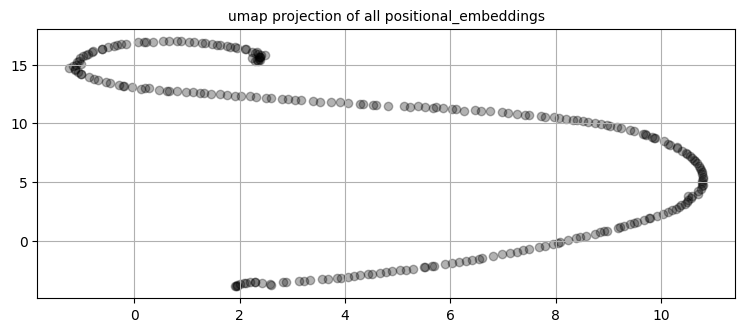

In [29]:
plt.scatter(embedding[:,0],embedding[:,1], c='k', alpha=.3)
plt.title('umap projection of all positional_embeddings')
